## Model Evaluation Demo

We adopt the dataset from Genome-wide cell-free DNA fragmentation in patients with cancer as the example.

## Some Package Import and Data Preparation

In [1]:
import pandas as pd
from numpy import *
from sklearn import *


xl = pd.ExcelFile('data2.xlsx')
xl.sheet_names # we'll take 7th
dfs = {sheet: xl.parse(sheet) for sheet in xl.sheet_names}
data1 = dfs['7']
data2 = dfs['1'].loc[:,['Patient','Age at Diagnosis']].drop([554]).drop_duplicates()
data3 = pd.read_csv('data1.csv')
combined_data = data1.set_index('Patient').join(data2.set_index('Patient')).join(data3.set_index('Patient'))
combined_data['label'] = (combined_data['Patient Type'] == 'Healthy').astype(int)
combined_data = combined_data.drop(['Patient Type'],axis=1)
print('The number of samples and features are %d and %d, respectively'%(combined_data.shape[0],combined_data.shape[1]))

x = combined_data.iloc[:, 0:44]
x[isnan(x)] = 0
y=combined_data.iloc[:,44]

D:\Program files\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Program files\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, defaultdict
D:\Program files\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d

The number of samples and features are 423 and 45, respectively


## Holdout Method

In [47]:
##---  Evaluate a SVM model using holdout method ---##

from sklearn.model_selection import train_test_split

##---  Split the dataset into training set and test set ---##
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
##---  creat and train the model ---##
clf = svm.SVC(kernel = 'rbf', gamma='auto', probability=True).fit(x_train,y_train)
##---  Make the prediction ---##
y_pred = clf.predict(x_test)

##---  Evaluate model: we use the accuracy as the example ---##
scores = metrics.accuracy_score(y_test, y_pred)
##---  Report performance ---##
print('Accuracy: %.2f (%.2f)' % (mean(scores), std(scores)))

Accuracy: 0.91 (0.00)


## K-fold cross validation

In [49]:
##---  Evaluate a SVM model using k-fold cross-validation ---##

from sklearn.model_selection import KFold

##---  Prepare the cross-validation procedure ---##
KF = KFold(n_splits=5,shuffle=True, random_state=920)
##---   If we want to make sure that the proportion of samples in the training and test set is the same as in the original dataset, we should adopt 'StratifiedKFold' ---##
# KF = StratifiedKFold(n_outer,shuffle=True, random_state=920+i)

scores = []
for train_index,test_index in KF.split(x,y):
    ##---  Seperate traing set and test set ---##
    x_train, x_test = x.iloc[train_index][:], x.iloc[test_index][:]
    y_train, y_test = y.iloc[train_index][:],y.iloc[test_index][:]
    ##---  creat and train the model ---##
    clf = svm.SVC(kernel = 'rbf', gamma='auto', probability=True).fit(x_train,y_train)
    ##---  Make the prediction ---##
    y_pred = clf.predict(x_test)
    ##---  Evaluate model on the specific test set ---##
    score = metrics.accuracy_score(y_test, y_pred)
    scores.append(score) 

##---  Report performance ---##
print('Accuracy: %.2f (%.2f)' % (mean(scores), std(scores)))

Accuracy: 0.86 (0.03)


## Bootstraping

In [53]:
##---  Evaluate a SVM model using 0.632+bootstrap ---##

from mlxtend.evaluate import bootstrap_point632_score,BootstrapOutOfBag


##---  Prepare the bootstrap procedure ---##
oob = BootstrapOutOfBag(n_splits=1,random_seed = 920)

scores = []
for train_index, test_index in oob.split(x,y):
    ##---  Seperate traing set and test set ---##
    x_train, x_test = x.iloc[train_index][:], x.iloc[test_index][:]
    y_train, y_test = y.iloc[train_index][:],y.iloc[test_index][:]
    ##---  creat and train the model ---##
    clf = svm.SVC(kernel = 'rbf', gamma='auto', probability=True).fit(x_train,y_train)
    ##---  Make the prediction ---##
    y_predtrain = clf.predict(x_train)
    y_pred = clf.predict(x_test)
    
    ##---  Evaluate model on the specific test set ---##
    
    # Compute error
    E_resub = metrics.accuracy_score(y_train, y_predtrain)
    E_loop = metrics.accuracy_score(y_test, y_pred)
    # compute no-information-rate
    y_pred = clf.predict(x)
    length = len(y_pred)
    gamma = sum(y==0)/length*(1-sum(y_pred==0)/length)+sum(y==1)/length*(1-sum(y_pred==1)/length)
    # compute error under 0.632
    E_632 = 0.368*E_resub + 0.632*E_loop
    # compute R
    if gamma > E_resub:
        R = (E_loop - E_resub) / (gamma - E_resub)
    else:
        R = 0
        E_resub = gamma
    # compute error under 0.632+
    E_632plus = E_632 + (E_resub - E_loop)*(0.368*0.632*R/(1-0.368*R))
    scores.append(E_632plus) 

##---  Report performance ---##
print('Accuracy: %.2f (%.2f)' % (mean(scores), std(scores)))

Accuracy: 0.88 (0.00)


## Performance Evaluation Metrics

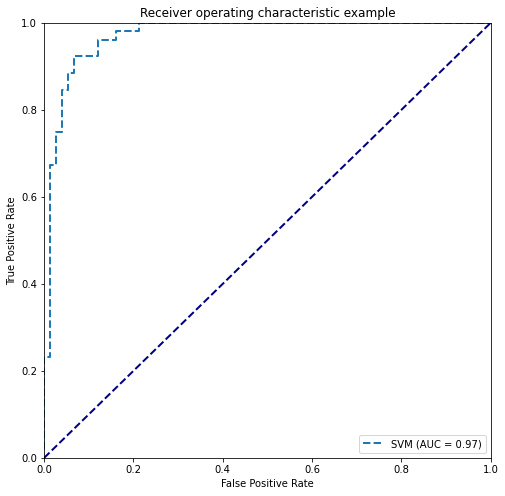

Confusion matrix is:
 [[67  8]
 [ 4 48]]
Accuracy is 0.91
Precision is 0.86
Recall is 0.92
F1 is 0.89
F_beta is 1.11
Brier score is 0.07
AUC is 0.97



In [52]:
##---  Evaluate a SVM model using different performance evaluation metrics under holdout method ---##
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

##---  Split the dataset into training set and test set ---##
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
##---  creat and train the model ---##
clf = svm.SVC(kernel = 'rbf', gamma='auto', probability=True).fit(x_train,y_train)
##---  Make the prediction ---##
y_pred = clf.predict(x_test)
y_score = clf.predict_proba(x_test)

##---  Different performance evaluation metrics ---##
# Confusion matrix
cm = metrics.confusion_matrix(y_test,y_pred)
# Accuracy
a = metrics.accuracy_score(y_test, y_pred)
# Precision
p = metrics.precision_score(y_test, y_pred)
# Recall
r = metrics.recall_score(y_test, y_pred)
# F_1 score
f1score = metrics.f1_score(y_test, y_pred)
# F_beta score
beta = 2
Fbeta = metrics.f1_score(y_test, y_pred)/2*((1+beta**2)/beta)
# Brier score
BS = metrics.brier_score_loss(y_test, y_score[:,1])

# Calculate AUC
fpr, tpr, threshold = metrics.roc_curve(y_test, y_score[:,1], pos_label=1)
roc_auc = metrics.auc(fpr,tpr)
# Plot ROC
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, lw=2, label='SVM (AUC = %0.2f)' % roc_auc, linestyle='--')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

##---  Report performance ---##
print('Confusion matrix is:\n',cm)
print('Accuracy is %0.2f\nPrecision is %0.2f\nRecall is %0.2f\nF1 is %0.2f'% (a, p, r, f1score))
print('F_beta is %0.2f\nBrier score is %0.2f\nAUC is %0.2f\n'% (Fbeta,BS,roc_auc))